# Comparison Between TreeValue and Tianshou Batch

In this section, we will take a look at the feature and performance of the [Tianshou Batch](https://github.com/thu-ml/tianshou) library, which is developed by Tsinghua Machine Learning Group.

Before starting the comparison, let us define some thing.

In [1]:
import torch 

_TREE_DATA_1 = {'a': 1, 'b': 2, 'x': {'c': 3, 'd': 4}}
_TREE_DATA_2 = {
    'a': torch.randn(2, 3), 
    'x': {
        'c': torch.randn(3, 4)
    },
}
_TREE_DATA_3 = {
    'obs': torch.randn(4, 84, 84),
    'action': torch.randint(0, 6, size=(1,)),
    'reward': torch.rand(1),
}

## Read and Write Operation

Reading and writing are the two most common operations in the tree data structure based on the data model (TreeValue and Tianshou Batch both belong to this type), so this section will compare the reading and writing performance of these two libraries.

### TreeValue's Get and Set

In [2]:
from treevalue import FastTreeValue

t = FastTreeValue(_TREE_DATA_2)

/home/runner/work/treevalue/treevalue/treevalue/tree/integration/torch.py:23: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  register_for_torch(TreeValue)
/home/runner/work/treevalue/treevalue/treevalue/tree/integration/torch.py:24: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  register_for_torch(FastTreeValue)


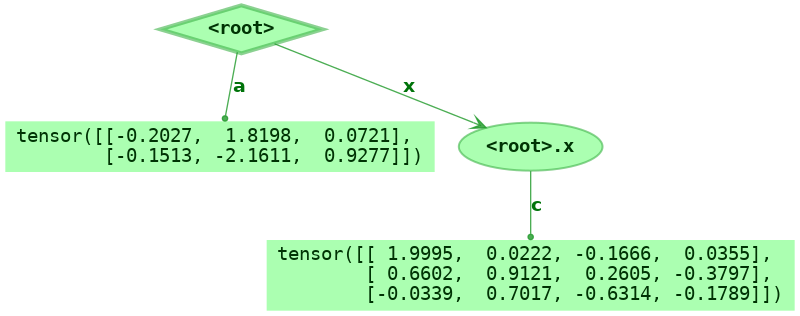

In [3]:
t

In [4]:
t.a

tensor([[-0.2027,  1.8198,  0.0721],
        [-0.1513, -2.1611,  0.9277]])

In [5]:
%timeit t.a

46.8 ns ± 0.139 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


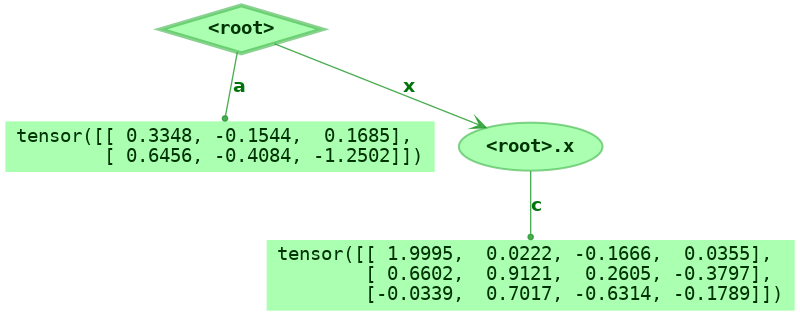

In [6]:
new_value = torch.randn(2, 3)
t.a = new_value

t

In [7]:
%timeit t.a = new_value

50.2 ns ± 0.294 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


### Tianshou Batch's Get and Set

In [8]:
from tianshou.data import Batch

b = Batch(**_TREE_DATA_2)

In [9]:
b

Batch(
    a: tensor([[-0.2027,  1.8198,  0.0721],
               [-0.1513, -2.1611,  0.9277]]),
    x: Batch(
           c: tensor([[ 1.9995,  0.0222, -0.1666,  0.0355],
                      [ 0.6602,  0.9121,  0.2605, -0.3797],
                      [-0.0339,  0.7017, -0.6314, -0.1789]]),
       ),
)

In [10]:
b.a

tensor([[-0.2027,  1.8198,  0.0721],
        [-0.1513, -2.1611,  0.9277]])

In [11]:
%timeit b.a

43.5 ns ± 0.394 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [12]:
new_value = torch.randn(2, 3)
b.a = new_value

b

Batch(
    a: tensor([[ 1.1028,  1.5649,  1.4587],
               [ 0.7384, -0.4992, -0.3674]]),
    x: Batch(
           c: tensor([[ 1.9995,  0.0222, -0.1666,  0.0355],
                      [ 0.6602,  0.9121,  0.2605, -0.3797],
                      [-0.0339,  0.7017, -0.6314, -0.1789]]),
       ),
)

In [13]:
%timeit b.a = new_value

378 ns ± 4.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


## Initialization

### TreeValue's Initialization

In [14]:
%timeit FastTreeValue(_TREE_DATA_1)

6.74 µs ± 46.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Tianshou Batch's Initialization

In [15]:
%timeit Batch(**_TREE_DATA_1)

8.46 µs ± 45.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Deep Copy Operation

In [16]:
import copy

### Deep Copy of TreeValue

In [17]:
t3 = FastTreeValue(_TREE_DATA_3)
%timeit copy.deepcopy(t3)

129 µs ± 734 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Deep Copy of Tianshou Batch

In [18]:
b3 = Batch(**_TREE_DATA_3)
%timeit copy.deepcopy(b3)

128 µs ± 776 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Stack, Concat and Split Operation

### Performance of TreeValue

In [19]:
trees = [FastTreeValue(_TREE_DATA_2) for _ in range(8)]

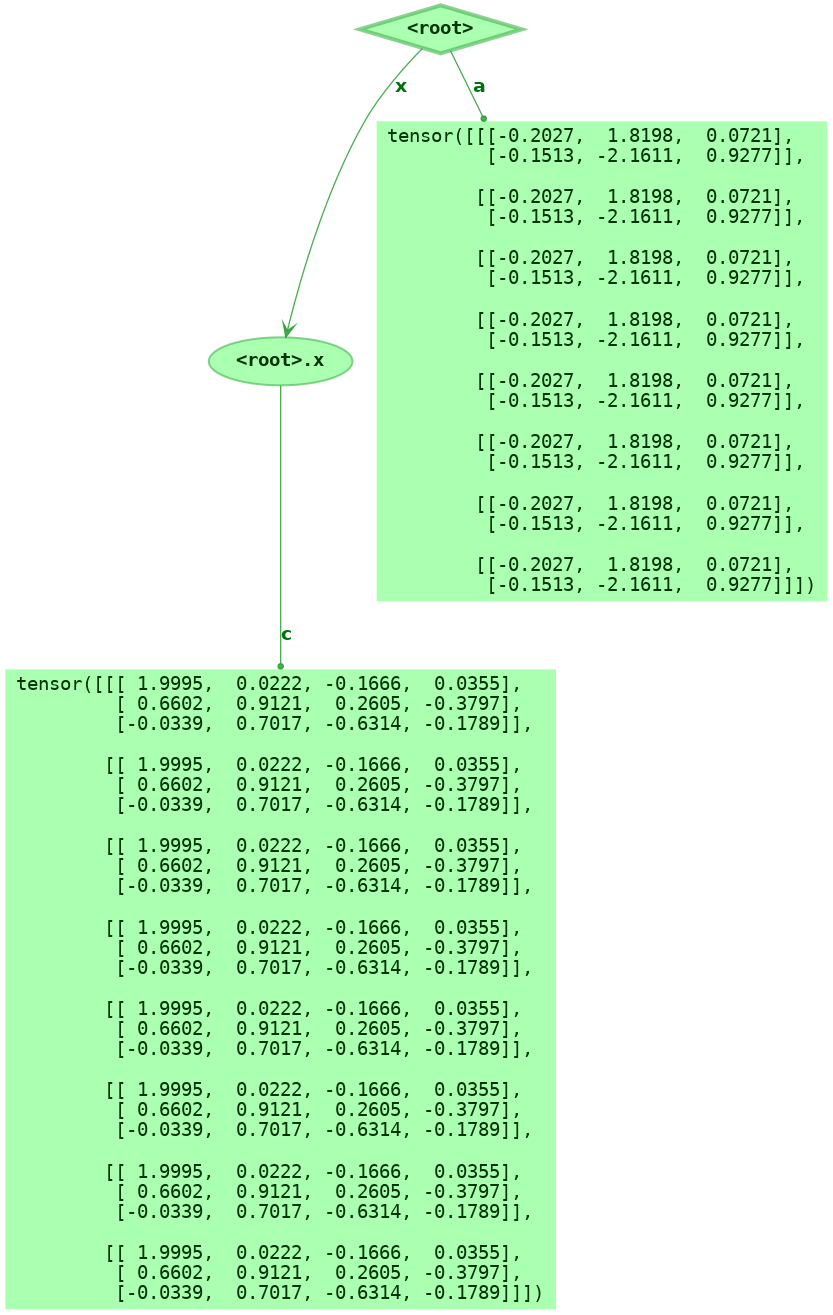

In [20]:
t_stack = FastTreeValue.func(subside=True)(torch.stack)

t_stack(trees)

In [21]:
%timeit t_stack(trees)

23.7 µs ± 251 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


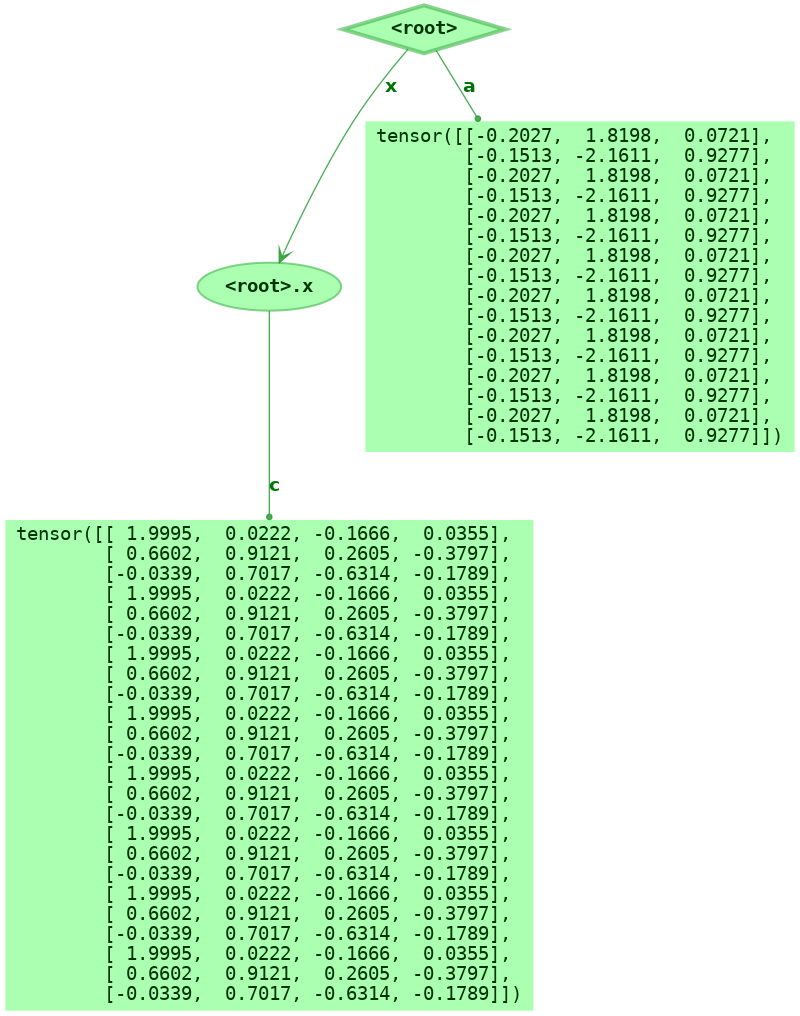

In [22]:
t_cat = FastTreeValue.func(subside=True)(torch.cat)

t_cat(trees)

In [23]:
%timeit t_cat(trees)

21.8 µs ± 58.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [24]:
t_split = FastTreeValue.func(rise=True)(torch.split)
tree = FastTreeValue({
    'obs': torch.randn(8, 4, 84, 84),
    'action': torch.randint(0, 6, size=(8, 1,)),
    'reward': torch.rand(8, 1),
})

%timeit t_split(tree, 1)

50.3 µs ± 129 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Performance of Tianshou Batch

In [25]:
batches = [Batch(**_TREE_DATA_2) for _ in range(8)]

Batch.stack(batches)

Batch(
    x: Batch(
           c: tensor([[[ 1.9995,  0.0222, -0.1666,  0.0355],
                       [ 0.6602,  0.9121,  0.2605, -0.3797],
                       [-0.0339,  0.7017, -0.6314, -0.1789]],
              
                      [[ 1.9995,  0.0222, -0.1666,  0.0355],
                       [ 0.6602,  0.9121,  0.2605, -0.3797],
                       [-0.0339,  0.7017, -0.6314, -0.1789]],
              
                      [[ 1.9995,  0.0222, -0.1666,  0.0355],
                       [ 0.6602,  0.9121,  0.2605, -0.3797],
                       [-0.0339,  0.7017, -0.6314, -0.1789]],
              
                      [[ 1.9995,  0.0222, -0.1666,  0.0355],
                       [ 0.6602,  0.9121,  0.2605, -0.3797],
                       [-0.0339,  0.7017, -0.6314, -0.1789]],
              
                      [[ 1.9995,  0.0222, -0.1666,  0.0355],
                       [ 0.6602,  0.9121,  0.2605, -0.3797],
                       [-0.0339,  0.7017, -0.6314, -0.1789]],

In [26]:
%timeit Batch.stack(batches)

63.1 µs ± 206 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [27]:
Batch.cat(batches)

Batch(
    x: Batch(
           c: tensor([[ 1.9995,  0.0222, -0.1666,  0.0355],
                      [ 0.6602,  0.9121,  0.2605, -0.3797],
                      [-0.0339,  0.7017, -0.6314, -0.1789],
                      [ 1.9995,  0.0222, -0.1666,  0.0355],
                      [ 0.6602,  0.9121,  0.2605, -0.3797],
                      [-0.0339,  0.7017, -0.6314, -0.1789],
                      [ 1.9995,  0.0222, -0.1666,  0.0355],
                      [ 0.6602,  0.9121,  0.2605, -0.3797],
                      [-0.0339,  0.7017, -0.6314, -0.1789],
                      [ 1.9995,  0.0222, -0.1666,  0.0355],
                      [ 0.6602,  0.9121,  0.2605, -0.3797],
                      [-0.0339,  0.7017, -0.6314, -0.1789],
                      [ 1.9995,  0.0222, -0.1666,  0.0355],
                      [ 0.6602,  0.9121,  0.2605, -0.3797],
                      [-0.0339,  0.7017, -0.6314, -0.1789],
                      [ 1.9995,  0.0222, -0.1666,  0.0355],
                   

In [28]:
%timeit Batch.cat(batches)

118 µs ± 875 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [29]:
batch = Batch({
    'obs': torch.randn(8, 4, 84, 84),
    'action': torch.randint(0, 6, size=(8, 1,)),
    'reward': torch.rand(8, 1)}
)

%timeit list(Batch.split(batch, 1, shuffle=False, merge_last=True))

284 µs ± 5.39 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
